In [ ]:
## Basic imports
import sys
import os
import time
import pixiedust

# WARNING: These global declarations cause the parallel implementation to 
# crash when executed on Windows
connections = None
networks = None
flowdepthvel = None

from sys import platform
if platform == "linux" or platform == "linux2":
    pass
elif platform == "darwin":
    pass
elif platform == "win32":
    print('The parallel version of compute_nhd_routing.py will not execute as currently')
    print('written due to the lack of a fork() capability in the windows OS.')
    print('For parallel execution, please us a *nix OS.')
    print('\nexiting...')
    sys.exit()
    # Some useful references:
    # https://stackoverflow.com/questions/985281/what-is-the-closest-thing-windows-has-to-fork/985525#985525
    # https://stackoverflow.com/questions/8220108/how-do-i-check-the-operating-system-in-python
    # https://stackoverflow.com/questions/6596617/python-multiprocess-diff-between-windows-and-linux

ENV_IS_CL = False
if ENV_IS_CL: root = '/content/wrf_hydro_nwm_public/trunk/NDHMS/dynamic_channel_routing/'
elif not ENV_IS_CL: 
    sys.setrecursionlimit(4000)
    #root = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
    root=os.path.abspath('')
    #print(root)
    root=os.path.dirname(os.path.abspath(''))
    #print(root)    
    root=os.path.dirname(os.path.dirname(os.path.abspath('')))
    #print(root)    
    #root = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(''))))
    print(root)
    
    sys.path.append(os.path.join(root, r'src', r'python_framework'))
    fortran_source_dir = os.path.join(root, r'src', r'fortran_routing', r'mc_pylink_v00', r'MC_singleRCH_singleTS')
#     print(fortran_source_dir) 
    sys.path.append(fortran_source_dir)
print(sys.path)
from mc_singleCh_SingleTStep import compute_mc_reach_up2down 
# import mc_sc_stime as mc
# import mc_sseg_stime_noIC as mc

# Build supernetwork_data, supernetwork_values

In [ ]:
#%%pixie_debugger 
#def main():
import nhd_network_utilities as nnu
import nhd_reach_utilities as nru

## Muskingum Cunge
import numpy as np

if 1==1:
    global connections
    global networks
    global flowdepthvel

    verbose = True
    debuglevel = 0
    showtiming = True

    test_folder = os.path.join(root, r'test')
    geo_input_folder = os.path.join(test_folder, r'input', r'geo', r'Channels')
    print(geo_input_folder)

    #TODO: Make these commandline args
    """##NHD Subset (Brazos/Lower Colorado)"""
#    supernetwork = 'Brazos_LowerColorado_ge5'  #this
#     supernetwork= 'Pocono_TEST1'
    """##NHD CONUS order 5 and greater"""
    # supernetwork = 'CONUS_ge5'
    """These are large -- be careful"""
    supernetwork = 'Mainstems_CONUS'
    # supernetwork = 'CONUS_FULL_RES_v20'
    # supernetwork = 'CONUS_Named_Streams' #create a subset of the full resolution by reading the GNIS field
    # supernetwork = 'CONUS_Named_combined' #process the Named streams through the Full-Res paths to join the many hanging reaches

    if verbose: print('creating supernetwork connections set')
    if showtiming: start_time = time.time()
    #STEP 1
    supernetwork_data, supernetwork_values = nnu.set_networks(
        supernetwork = supernetwork
        , geo_input_folder = geo_input_folder
        , verbose = False
        # , verbose = verbose
        , debuglevel = debuglevel
        )
    if verbose: print('supernetwork connections set complete')
    if showtiming: print("... in %s seconds." % (time.time() - start_time))

# TESTnnu.set_networks 

## In compute_nhd_routing.py,
    #STEP 1
    supernetwork_data, supernetwork_values = nnu.set_networks(
        supernetwork = supernetwork
        , geo_input_folder = geo_input_folder
        , verbose = False
        # , verbose = verbose
        , debuglevel = debuglevel
        )
## Then, in nhd_network_utilities.py
def set_networks(
    supernetwork = ''
    , geo_input_folder = None
    , verbose = True
    , debuglevel = 0
    ):

    supernetwork_data = set_supernetwork_data(
      supernetwork = supernetwork
      , geo_input_folder = geo_input_folder
      ) 
    supernetwork_values = get_nhd_connections(
      supernetwork_data = supernetwork_data
      , verbose = verbose
      , debuglevel = debuglevel
      )
    return supernetwork_data, supernetwork_values



In [ ]:
#%%pixie_debugger 
# def set_networks(
#     supernetwork = ''
#     , geo_input_folder = None
#     , verbose = True
#     , debuglevel = 0
#     ):

supernetwork_data = {
            'geo_file_path' : os.path.join(geo_input_folder
                    , r'PoconoSampleRouteLink1.shp')
            , 'key_col' : 18
            , 'downstream_col' : 23
            , 'length_col' : 5
            , 'manningn_col' : 20
            , 'manningnCC_col' : 21
            , 'slope_col' : 10   
            , 'bottomwidth_col' : 2
            , 'topwidth_col' : 11
            , 'topwidthCC_col' : 12
            , 'MusK_col' : 6
            , 'MusX_col' : 7
            , 'ChSlp_col' : 3
            , 'terminal_code' : 0
            , 'title_string' : 'Pocono Test Example'
            , 'driver_string' : 'ESRI Shapefile'
            , 'layer_string' : 0
          }

print(supernetwork_data)


In [ ]:
#     supernetwork_values = get_nhd_connections(
#       supernetwork_data = supernetwork_data
#       , verbose = verbose
#       , debuglevel = debuglevel
#       )
#     return supernetwork_data, supernetwork_values

if 1==1: 
#def get_nhd_connections(
#     supernetwork_data = {}
#     , debuglevel = 0
#     , verbose = False
#     ):
    if 'mask_file_path' not in supernetwork_data:
        #TODO: doing things this way may mean we are reading the same file twice -- fix this [maybe] by implementing an overloaded return
        supernetwork_data.update({'mask_file_path':None})
        supernetwork_data.update({'mask_layer_string':None})
        supernetwork_data.update({'mask_driver_string':None})
        supernetwork_data.update({'mask_key_col':None})
# ** Here do_connnections is another defined function in nhd_network_utilities.py that subsequently call
# another functions so on and so forth so it's quite hard to bring multiple defined functions here 
# in order to run independently here.

    return do_connections(
            geo_file_path = supernetwork_data['geo_file_path']
          , key_col = supernetwork_data['key_col']
          , downstream_col = supernetwork_data['downstream_col']
          , length_col = supernetwork_data['length_col']
          , terminal_code = supernetwork_data['terminal_code']
          , title_string = supernetwork_data['title_string']
          , driver_string = supernetwork_data['driver_string']
          , layer_string = supernetwork_data['layer_string']
          , mask_file_path = supernetwork_data['mask_file_path']
          , mask_layer_string = supernetwork_data['mask_layer_string']
          , mask_driver_string = supernetwork_data['mask_driver_string']
          , mask_key_col = supernetwork_data['mask_key_col']
          , debuglevel = debuglevel
          , verbose = verbose
        )
   

In [ ]:
print(supernetwork_values)


In [8]:
print(type(supernetwork_data))
print(f'supernetwork_data->  {supernetwork_data}')
print()
print()
# print(type(supernetwork_values))
print(supernetwork_values[0][4153018])
print()
print(supernetwork_values[0][4153018]['data'][supernetwork_data['length_col']])
print(supernetwork_values[0][4153018]['data'][supernetwork_data['MusK_col']])
print(supernetwork_values[0][4153018]['data'][supernetwork_data['slope_col']])

print(supernetwork_values)


<class 'dict'>
supernetwork_data->  {'geo_file_path': '/home/dongha.kim/github/wrf_hydro_nwm_public/trunk/NDHMS/dynamic_channel_routing/test/input/geo/Channels/PoconoSampleRouteLink1.shp', 'key_col': 18, 'downstream_col': 23, 'length_col': 5, 'manningn_col': 20, 'manningnCC_col': 21, 'slope_col': 10, 'bottomwidth_col': 2, 'topwidth_col': 11, 'topwidthCC_col': 12, 'MusK_col': 6, 'MusX_col': 7, 'ChSlp_col': 3, 'terminal_code': 0, 'title_string': 'Pocono Test Example', 'driver_string': 'ESRI Shapefile', 'layer_string': 0}




KeyError: 4153018

## supernetwork_data
It is a dictionary

## supernetwork_values
tuple(dictionary(key:value=dictionary))


In [7]:
#supernetwork_data
#for consupernetwork_values[0]
i=0
# for k, v in supernetwork_values[0].items():
#     print(con,values['upstreams'],['data'])
#     print(k,v['downstream']) 
#     print(k,v['length'])
#     print(k,v['data'])
#     print(k,v['upstreams'])
#     print()
#     i=i+1
#     if i==4:
#         break



# print(type(supernetwork_values[2]))
# print(supernetwork_values)
len(supernetwork_values)
        
# with open(os.path.join(os.path.abspath(''),"supernetwork_values"),'w') as snval:
#     for t in range(0,len(supernetwork_values)):
#         snval.write("%s %s %s %s %s\n" % (t, Qup_ds[i][1][t], depth_vel[i][0][t], depth_vel[i][1][t], ql_hyd[i][t]))   

11

# Build networks

In [9]:
if 1==1: 
    #STEP 2
    if showtiming: start_time = time.time()
    if verbose: print('organizing connections into networks and reaches ...')
    networks = nru.compose_reaches(
        supernetwork_values
        , verbose = False
        # , verbose = verbose
        , debuglevel = debuglevel
        , showtiming = showtiming
        )
    if verbose: print('reach organization complete')
    if showtiming: print("... in %s seconds." % (time.time() - start_time))

organizing connections into networks and reaches ...
reach organization complete
... in 0.14307451248168945 seconds.


## networks key:value description

### 1. total_segment_count
    2nd-tier key the value of which is the number of links that have the values of 'to' of non-zero.

### 2. junctions: 
    2nd-tier key the value of which indicates any links immed. downstream of junctions in the upstream of a link of 1st-tier key.
#4186309 junctions: {4185665, 4186305, 4186309, 4186255}
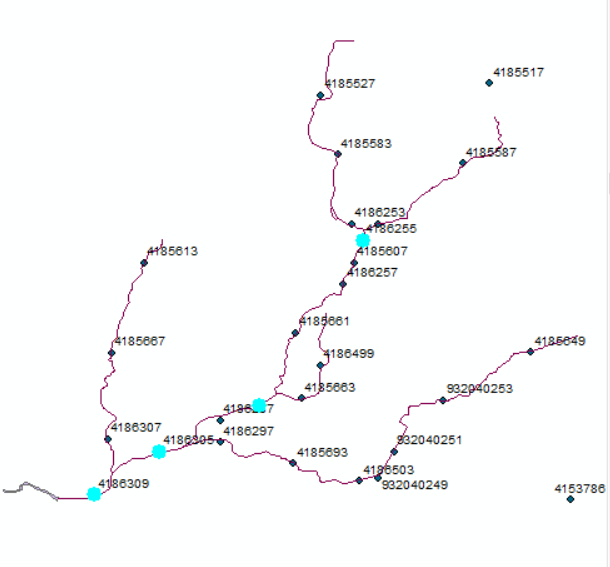
    ** Picture for the first-tier key to a link that is in the lower end of NHD network.

### 3. headwater_reaches
    2nd-tier key the values of which are link values in head-water basins in the upstream of 1st-tier key being a link.
#4186309 headwater_reaches: {4186499, 4185613, 4185517, 4185649, 4185527}
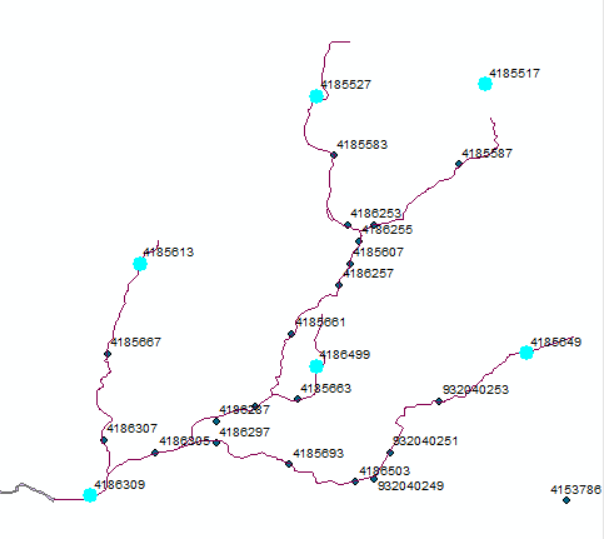
    
### 4. reaches-segments
#4186309 reaches-4185517-segments: {4186251, 4185517, 4185587}
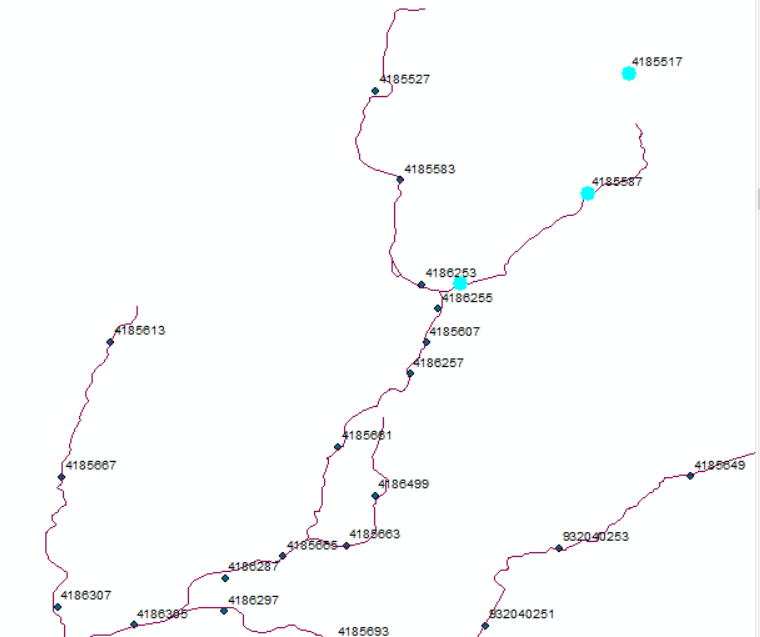
#4186309 reaches-4186255-segments: {4186255, 4186257, 4185661, 4185607}
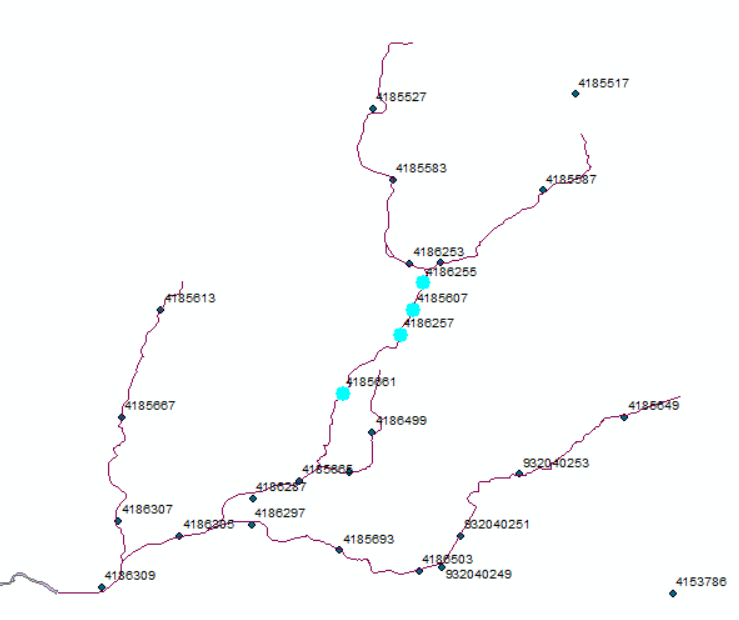

### 5. reaches-upstream_reaches

#4186309 reaches-4185665-upstream_reaches: {4186499, 4186255}
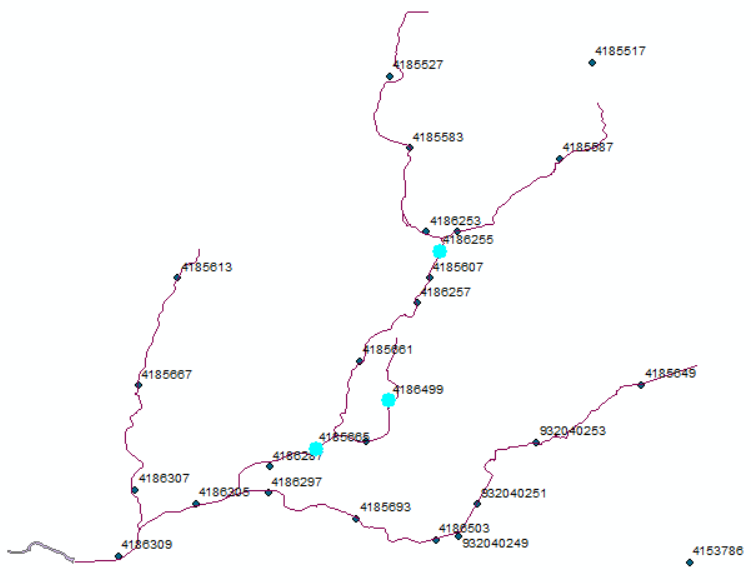

#4186309 reaches-4186305-upstream_reaches: {4185665, 4185649}
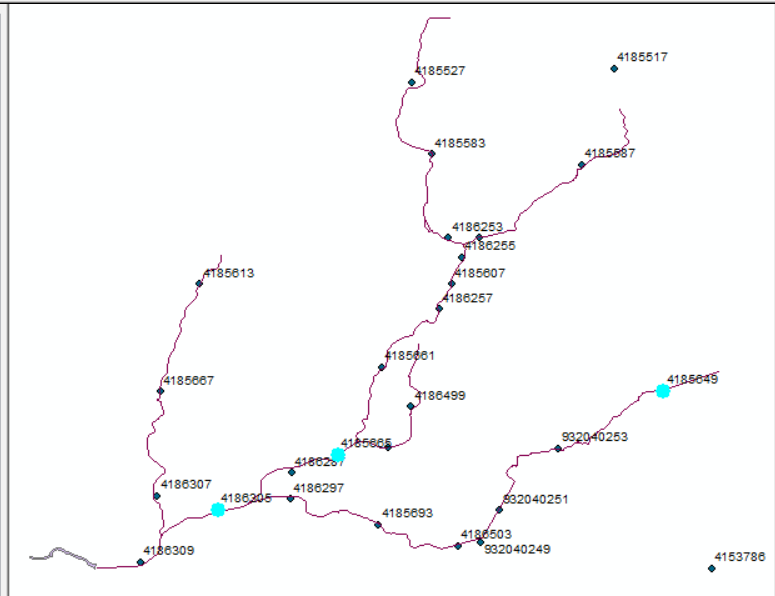

#4186309 reaches-4186309-upstream_reaches: {4186305, 4185613}
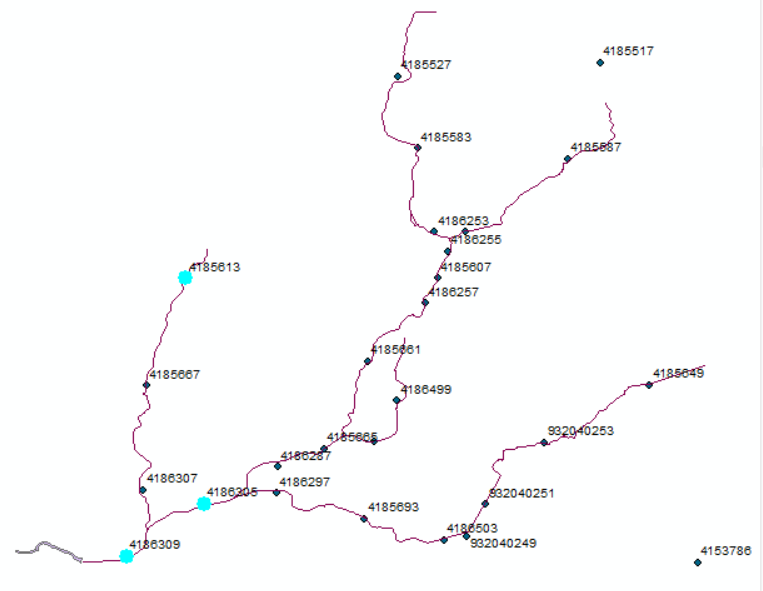

### 6. reaches-reach_tail and -reach_head
#4186309 reaches-4185517-reach_tail: 4186251
#4186309 reaches-4185517-downstream_reach: 4186255 
#4186309 reaches-4185517-reach_head: 4185517


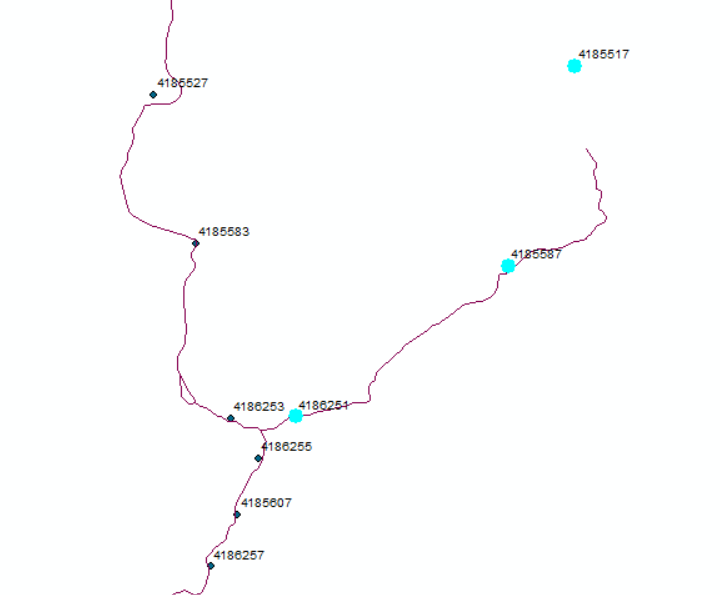
    


In [10]:
# print(networks)
# networks key: links that take zero for attribute 'to' & link that locates at the lower end of a network.
#               That is, all keys of networks dictionary are terminal_reach            
for k, v in networks.items():
    print(k)
    print(v)


20331522
{'total_segment_count': 5, 'total_junction_count': 0, 'maximum_reach_seqorder': 0, 'junctions': set(), 'headwater_reaches': {20331516}, 'reaches': {20331516: {'reach_tail': 20331522, 'downstream_reach': 0, 'reach_head': 20331516, 'seqorder': 0, 'segments': {20331520, 20331522, 20331512, 20331514, 20331516}, 'segments_list': [20331522, 20331514, 20331512, 20331520, 20331516], 'upstream_reaches': {0}}}, 'terminal_reach': 20331516}
2245123
{'total_segment_count': 286, 'total_junction_count': 1, 'maximum_reach_seqorder': 1, 'junctions': {2238897}, 'headwater_reaches': {2210130, 2188031}, 'reaches': {2238897: {'reach_tail': 2245123, 'downstream_reach': 0, 'reach_head': 2238897, 'seqorder': 0, 'segments': {2245121, 2245123, 2242053, 2242055, 2245129, 2242059, 2245133, 2245135, 2242065, 2242067, 2242075, 2242079, 2242081, 2242087, 2242089, 2242093, 2242097, 2242103, 2242107, 2242111, 2242113, 2242117, 2242125, 2242133, 2242141, 2242143, 2242149, 2242153, 2242155, 2242159, 2242161, 22

In [ ]:
reaches_dic={}
reach_tail_dic={}
downstream_reach_dic=[]

for k in networks.keys():
    print(k)

# for v in networks.values():
#     print(v)
# values corresponding only to a given key (here link 4186309)
print("4186309 total_segment_count: %3d" %(networks[4186309]['total_segment_count']))
print("4186309 total_segment_count: %3d" %(networks[4186309]['total_junction_count']))
print("4186309 junctions: {}".format(networks[4186309]['junctions']))
print("4186309 headwater_reaches: {}".format(networks[4186309]['headwater_reaches']))

# values corresponding to the values of 'junctions' and 'headwater_reaches' related to a given key (here link 4186309)
print("4186309 reaches-4186309-reach_tail: {}".format(networks[4186309]['reaches'][4186309]['reach_tail']))
print("4186309 reaches-4186309-downstream_reach: {}".format(networks[4186309]['reaches'][4186309]['downstream_reach']))
print("4186309 reaches-4186309-reach_head: {}".format(networks[4186309]['reaches'][4186309]['reach_head']))
print("4186309 reaches-4186309-seqorder: {}".format(networks[4186309]['reaches'][4186309]['seqorder']))
print("4186309 reaches-4186309-segments: {}".format(networks[4186309]['reaches'][4186309]['segments']))
print("4186309 reaches-4186309-upstream_reaches: {}".format(networks[4186309]['reaches'][4186309]['upstream_reaches']))
print()
print("4186309 reaches-4186305-reach_tail: {}".format(networks[4186309]['reaches'][4186305]['reach_tail']))
print("4186309 reaches-4186305-downstream_reach: {}".format(networks[4186309]['reaches'][4186305]['downstream_reach']))
print("4186309 reaches-4186305-reach_head: {}".format(networks[4186309]['reaches'][4186305]['reach_head']))
print("4186309 reaches-4186305-seqorder: {}".format(networks[4186309]['reaches'][4186305]['seqorder']))
print("4186309 reaches-4186305-segments: {}".format(networks[4186309]['reaches'][4186305]['segments']))
print("4186309 reaches-4186305-upstream_reaches: {}".format(networks[4186309]['reaches'][4186305]['upstream_reaches']))
print()
print("4186309 reaches-4185665-reach_tail: {}".format(networks[4186309]['reaches'][4185665]['reach_tail']))
print("4186309 reaches-4185665-downstream_reach: {}".format(networks[4186309]['reaches'][4185665]['downstream_reach']))
print("4186309 reaches-4185665-reach_head: {}".format(networks[4186309]['reaches'][4185665]['reach_head']))
print("4186309 reaches-4185665-seqorder: {}".format(networks[4186309]['reaches'][4185665]['seqorder']))
print("4186309 reaches-4185665-segments: {}".format(networks[4186309]['reaches'][4185665]['segments']))
print("4186309 reaches-4185665-upstream_reaches: {}".format(networks[4186309]['reaches'][4185665]['upstream_reaches']))
print()
print("4186309 reaches-4186255-reach_tail: {}".format(networks[4186309]['reaches'][4186255]['reach_tail']))
print("4186309 reaches-4186255-downstream_reach: {}".format(networks[4186309]['reaches'][4186255]['downstream_reach']))
print("4186309 reaches-4186255-reach_head: {}".format(networks[4186309]['reaches'][4186255]['reach_head']))
print("4186309 reaches-4186255-seqorder: {}".format(networks[4186309]['reaches'][4186255]['seqorder']))
print("4186309 reaches-4186255-segments: {}".format(networks[4186309]['reaches'][4186255]['segments']))
print("4186309 reaches-4186255-upstream_reaches: {}".format(networks[4186309]['reaches'][4186255]['upstream_reaches']))
print()
print("4186309 reaches-4185527-reach_tail: {}".format(networks[4186309]['reaches'][4185527]['reach_tail']))
print("4186309 reaches-4185527-downstream_reach: {}".format(networks[4186309]['reaches'][4185527]['downstream_reach']))
print("4186309 reaches-4185527-reach_head: {}".format(networks[4186309]['reaches'][4185527]['reach_head']))
print("4186309 reaches-4185527-seqorder: {}".format(networks[4186309]['reaches'][4185527]['seqorder']))
print("4186309 reaches-4185527-segments: {}".format(networks[4186309]['reaches'][4185527]['segments']))
print("4186309 reaches-4185527-upstream_reaches: {}".format(networks[4186309]['reaches'][4185527]['upstream_reaches']))
print()
print("4186309 reaches-4185517-reach_tail: {}".format(networks[4186309]['reaches'][4185517]['reach_tail']))
print("4186309 reaches-4185517-downstream_reach: {}".format(networks[4186309]['reaches'][4185517]['downstream_reach']))
print("4186309 reaches-4185517-reach_head: {}".format(networks[4186309]['reaches'][4185517]['reach_head']))
print("4186309 reaches-4185517-seqorder: {}".format(networks[4186309]['reaches'][4185517]['seqorder']))
print("4186309 reaches-4185517-segments: {}".format(networks[4186309]['reaches'][4185517]['segments']))
print("4186309 reaches-4185517-upstream_reaches: {}".format(networks[4186309]['reaches'][4185517]['upstream_reaches']))

# for k, v in networks[4186309].items():
#     reaches_dic={k:v}
# print(reaches_dic)

# for v in networks[4186309].values():
#     print(v)

# for (k1, v1) in reaches_dic.items():
#     reach_tail_dic={k1:v1}
# print(reach_tail_dic)
 

In [11]:
for k,v in networks.items():
#     print(f"key:{k}")
#     print(f"maximum_reach_seqorder:{v['maximum_reach_seqorder']}")
#     print(f"reaches:{v['reaches']}")
#     print()
    # seqorder for reach k1 counts the number of juctions in the downstream of k1 reach.
    for k1, v1 in v['reaches'].items():
          print(f"key-> {k}  reaches-> {k1}")
          print(f"key-> {k}  reaches-> {k1}  seqorder-> {v1['seqorder']}")                
          print()


key-> 20331522  reaches-> 20331516
key-> 20331522  reaches-> 20331516  seqorder-> 0

key-> 2245123  reaches-> 2238897
key-> 2245123  reaches-> 2238897  seqorder-> 0

key-> 2245123  reaches-> 2210130
key-> 2245123  reaches-> 2210130  seqorder-> 1

key-> 2245123  reaches-> 2188031
key-> 2245123  reaches-> 2188031  seqorder-> 1

key-> 23876101  reaches-> 23875777
key-> 23876101  reaches-> 23875777  seqorder-> 0

key-> 23876101  reaches-> 23875839
key-> 23876101  reaches-> 23875839  seqorder-> 1

key-> 23876101  reaches-> 23875925
key-> 23876101  reaches-> 23875925  seqorder-> 1

key-> 7703046  reaches-> 7700950
key-> 7703046  reaches-> 7700950  seqorder-> 0

key-> 7703046  reaches-> 7698948
key-> 7703046  reaches-> 7698948  seqorder-> 1

key-> 7703046  reaches-> 7698910
key-> 7703046  reaches-> 7698910  seqorder-> 2

key-> 7703046  reaches-> 6782113
key-> 7703046  reaches-> 6782113  seqorder-> 3

key-> 7703046  reaches-> 9331548
key-> 7703046  reaches-> 9331548  seqorder-> 4

key-> 770304


key-> 5867753  reaches-> 5867537
key-> 5867753  reaches-> 5867537  seqorder-> 0

key-> 10452202  reaches-> 8653194
key-> 10452202  reaches-> 8653194  seqorder-> 0

key-> 10452202  reaches-> 8677803
key-> 10452202  reaches-> 8677803  seqorder-> 1

key-> 10452202  reaches-> 8627883
key-> 10452202  reaches-> 8627883  seqorder-> 1

key-> 10452202  reaches-> 8632147
key-> 10452202  reaches-> 8632147  seqorder-> 2

key-> 10452202  reaches-> 8627261
key-> 10452202  reaches-> 8627261  seqorder-> 2

key-> 12018926  reaches-> 12021644
key-> 12018926  reaches-> 12021644  seqorder-> 0

key-> 23838450  reaches-> 23838568
key-> 23838450  reaches-> 23838568  seqorder-> 0

key-> 10736883  reaches-> 10744424
key-> 10736883  reaches-> 10744424  seqorder-> 0

key-> 23864566  reaches-> 23864616
key-> 23864566  reaches-> 23864616  seqorder-> 0

key-> 15623927  reaches-> 15626425
key-> 15623927  reaches-> 15626425  seqorder-> 0

key-> 25371895  reaches-> 15456882
key-> 25371895  reaches-> 15456882  seqorde

key-> 22811611  reaches-> 20973378  seqorder-> 14

key-> 22811611  reaches-> 20973160
key-> 22811611  reaches-> 20973160  seqorder-> 15

key-> 22811611  reaches-> 20972352
key-> 22811611  reaches-> 20972352  seqorder-> 16

key-> 22811611  reaches-> 20968828
key-> 22811611  reaches-> 20968828  seqorder-> 16

key-> 22811611  reaches-> 21035463
key-> 22811611  reaches-> 21035463  seqorder-> 17

key-> 22811611  reaches-> 20081772
key-> 22811611  reaches-> 20081772  seqorder-> 18

key-> 22811611  reaches-> 20081438
key-> 22811611  reaches-> 20081438  seqorder-> 19

key-> 22811611  reaches-> 20078342
key-> 22811611  reaches-> 20078342  seqorder-> 19

key-> 22811611  reaches-> 21166823
key-> 22811611  reaches-> 21166823  seqorder-> 18

key-> 22811611  reaches-> 21166813
key-> 22811611  reaches-> 21166813  seqorder-> 19

key-> 22811611  reaches-> 21165561
key-> 22811611  reaches-> 21165561  seqorder-> 20

key-> 22811611  reaches-> 22076733
key-> 22811611  reaches-> 22076733  seqorder-> 21

key

key-> 22811611  reaches-> 2441798  seqorder-> 41

key-> 22811611  reaches-> 2441840
key-> 22811611  reaches-> 2441840  seqorder-> 41

key-> 22811611  reaches-> 2442482
key-> 22811611  reaches-> 2442482  seqorder-> 42

key-> 22811611  reaches-> 2441950
key-> 22811611  reaches-> 2441950  seqorder-> 42

key-> 22811611  reaches-> 2440202
key-> 22811611  reaches-> 2440202  seqorder-> 38

key-> 22811611  reaches-> 2119984
key-> 22811611  reaches-> 2119984  seqorder-> 37

key-> 22811611  reaches-> 1875133
key-> 22811611  reaches-> 1875133  seqorder-> 38

key-> 22811611  reaches-> 1874965
key-> 22811611  reaches-> 1874965  seqorder-> 39

key-> 22811611  reaches-> 1104234
key-> 22811611  reaches-> 1104234  seqorder-> 40

key-> 22811611  reaches-> 2387136
key-> 22811611  reaches-> 2387136  seqorder-> 41

key-> 22811611  reaches-> 4142858
key-> 22811611  reaches-> 4142858  seqorder-> 42

key-> 22811611  reaches-> 4048826
key-> 22811611  reaches-> 4048826  seqorder-> 43

key-> 22811611  reaches-> 

# Build connections

In [16]:
if 1==1:
#STEP 3
    if showtiming: start_time = time.time()
    executiontype = 'serial' # 'parallel'

    if verbose: print('executing serial computation on ordered reaches ...')
    connections = supernetwork_values[0]
    print(len(connections))
    print(connections)
#     for k,v in connections.items():
#         print(k,v)

    #number_of_time_steps = 50 # one timestep
    #nts = 1440 # number fof timestep = 1140 * 60(model timestep) = 86400 = day
    
#     #initialize flowdepthvel dict
# # #     flowdepthvel = {connection:{'flow':np.zeros(number_of_time_steps + 1)
# #                                 , 'depth':np.zeros(number_of_time_steps + 1)
#                                 , 'vel':np.zeros(number_of_time_steps + 1)
#                                 , 'qlat':np.zeros(number_of_time_steps + 1)}
#                        for connection in connections
#                    } 
#     print(len(flowdepthvel))
#     for k, v in flowdepthvel.items():
#         print("key:{}".format(k))
#         print("'flow':{}".format(v['flow']))
#         print("'depth':{}".format(v['depth']))
#         print("'vel':{}".format(v['vel']))
#         print("'qlat':{}".format(v['qlat']))
#         print()
     #print(connections)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
    # from itertools import islice
    # def take(iterable, n):
    #     return list(islice(iterable, n))
    # import pdb; pdb.set_trace()

    if executiontype == 'serial':

        for terminal_segment, network in networks.items():
            if showtiming: network_start_time = time.time()
            compute_network(
                terminal_segment = terminal_segment
                , network = network
                , supernetwork_data = supernetwork_data
                , nts = number_of_time_steps
                # , connections = connections
                , verbose = False
                # , verbose = verbose
                , debuglevel = debuglevel
            )

            if verbose: print(f'{terminal_segment} completed')
            if showtiming: print("... in %s seconds." % (time.time() - network_start_time))
        
    if verbose: print('ordered reach computation complete')
    if showtiming: print("... in %s seconds." % (time.time() - start_time))

#if __name__ == '__main__':
#    main()


## Method #2: Adding nested list as value using append() method.

### Creating an empty dictionary 
myDict = {} 
  
### Adding list as value 
myDict["key1"] = [1, 2] 
  
### creating a list 
lst = ['Geeks', 'For', 'Geeks'] 
  
### Adding this list as sublist in myDict 
myDict["key1"].append(lst) 
  
print(myDict) 

Output:

{'key1': [1, 2, ['Geeks', 'For', 'Geeks']]}

# Build ordered_reaches

In [ ]:
#%%pixie_debugger
## network and reach utilities
# import nhd_network_utilities as nnu
# import nhd_reach_utilities as nru

## Muskingum Cunge
# import numpy as np

# def compute_network(
#         terminal_segment = None
#         , network = None
#         , supernetwork_data = None
#         , nts = None
        # , connections = None
#         , verbose = False
#         , debuglevel = 0
#         ):

#     global connections
#     global flowdepthvel 
# it=0

# Actually, all keys of networks dictionary are terminal_segment, the value of 'terminal_segment:' is 
# the key value itself. Now, network takes networks values corresponding to 'terminal_segment' keys. 
for terminal_segment, network in networks.items():
    ##TEST
#     it=it+1
#     if it==44:
#         break
#     print(f"for-loop: terminal_segment-> {terminal_segment}")
#     print(f"for-loop: network-> {network}")
#     print()
#     if verbose: print(f"Executing simulation on network {terminal_segment} beginning with streams of order {network['maximum_reach_seqorder']}")
    ordered_reaches = {}
    reach_flowdepthvel = {}
    last_segment_reach={}
    
    # head_segment = links that are either junctions or headwater_reaches belonged to terminal_segment link
    for head_segment, reach in network['reaches'].items():
#         print(f"    for-loop: head_segment-> {head_segment} ,----, reaches-> {reach}")
#         print()
#         print(f"    reach['seqorder']-> {reach['seqorder']},----, ordered_reaches-> {ordered_reaches}")
#         print()
        if reach['seqorder'] not in ordered_reaches:
            ordered_reaches.update({reach['seqorder']:[]}) #TODO: Should this be a set/dictionary?
#             print(f"        ordered_reaches-> {ordered_reaches}")
#             print()            
        ordered_reaches[reach['seqorder']].append([head_segment, reach])
#         print(f"    ordered_reaches-> {ordered_reaches}")
#         print()  
              
        #initialize flowdepthvel dict
#         reach_flowdepthvel.update({head_segment:{}})
#         reach_flowdepthvel[head_segment].update(
#             {seg:{'flow':{'prev':0, 'curr':0}
#                 , 'depth':{'prev':-999, 'curr':0}
#                 , 'vel':{'prev':0, 'curr':0}
#                 , 'qlat':{'prev':0, 'curr':0}} for seg in reach['segments']} 
#         )
# DONGHA NEW LINE        
        # store last segment link ID for each reach referenced by head_segment
        seg_list=list(reach['segments_list'])
#         segnb=len(reach['segments'])
        lastseg=seg_list[0]
        last_segment_reach[head_segment]= lastseg
#         print(f"last_segment_reach-> {last_segment_reach}")
#         print(f"--------------------------------")

print(len(networks))


## head_segment : reach for x

### x-> 4 in range 4
head_segment-> 4185517: reach-> {'reach_tail': 4186251, 'downstream_reach': 4186255, 'reach_head': 4185517, 'seqorder': 4, 'segments': {4186251, 4185517, 4185587}, 'upstream_reaches': {0}}
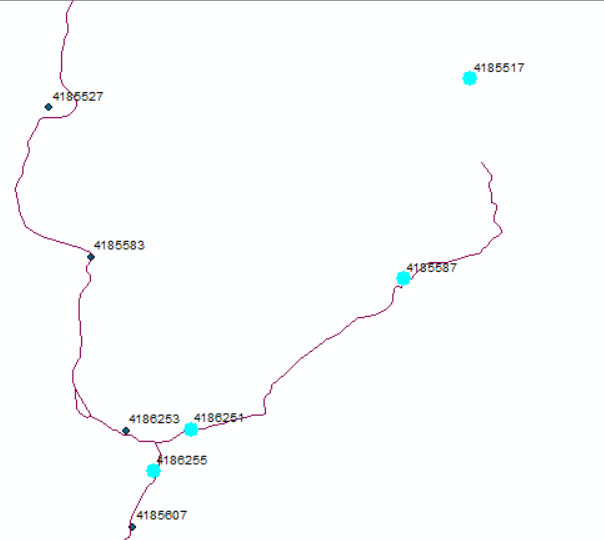

head_segment-> 4185527: reach-> {'reach_tail': 4186253, 'downstream_reach': 4186255, 'reach_head': 4185527, 'seqorder': 4, 'segments': {4185527, 4186253, 4185583}, 'upstream_reaches': {0}}
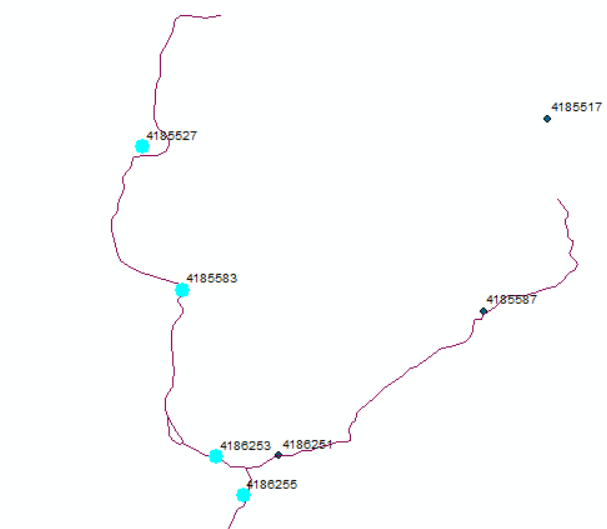

### x-> 3 in range 4
head_segment-> 4186255: reach-> {'reach_tail': 4185661, 'downstream_reach': 4185665, 'reach_head': 4186255, 'seqorder': 3, 'segments': {4186255, 4186257, 4185661, 4185607}, 'upstream_reaches': {4185517, 4185527}}
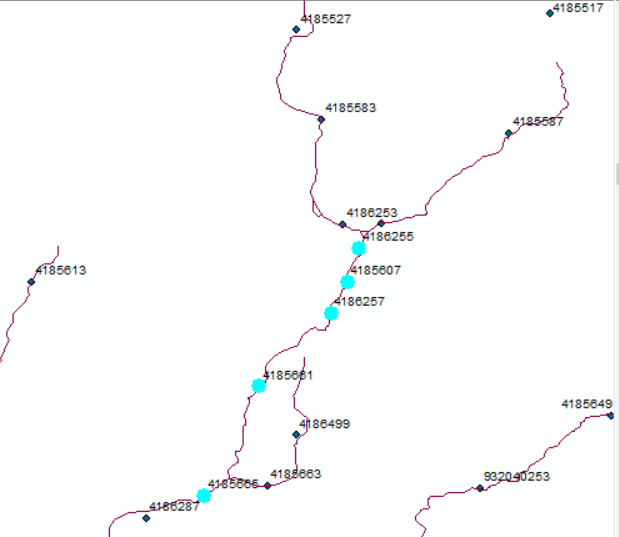

head_segment-> 4186499: reach-> {'reach_tail': 4185663, 'downstream_reach': 4185665, 'reach_head': 4186499, 'seqorder': 3, 'segments': {4186499, 4185663}, 'upstream_reaches': {0}}
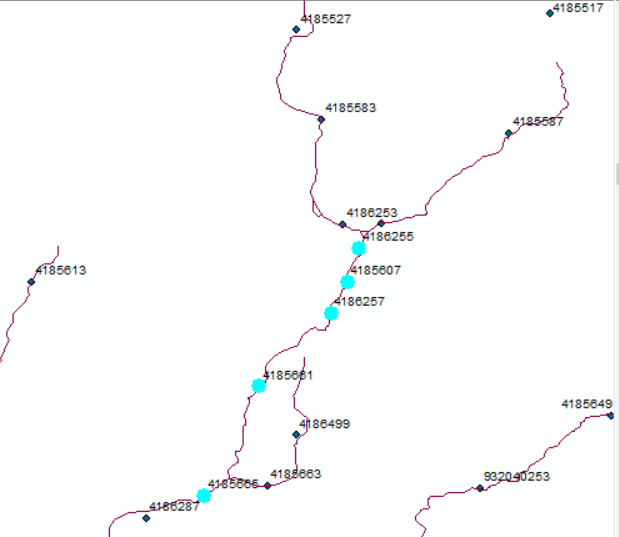

### x-> 0 in range 4
head_segment-> 4186309: reach-> {'reach_tail': 4186309, 'downstream_reach': 4185697, 'reach_head': 4186309, 'seqorder': 0, 'segments': {4186309}, 'upstream_reaches': {4186305, 4185613}}
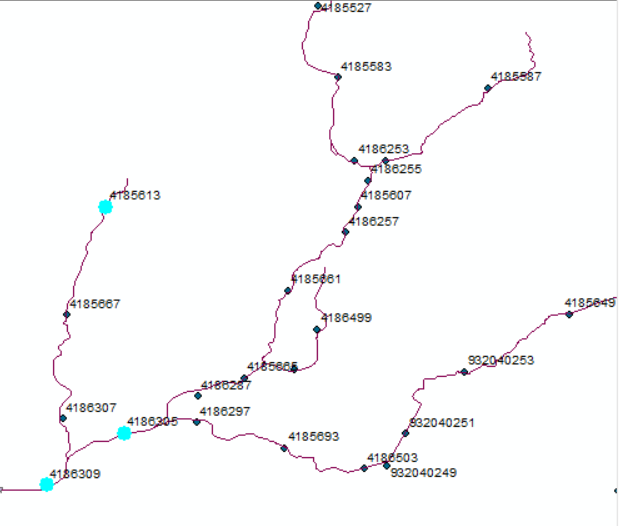


In [ ]:
# print(network)
#     print()
    #initialize flowdepthvel dict
nts=4
flowdepthvel = {connection:{'flow':np.zeros(nts)
                            , 'depth':np.zeros(nts)
                            , 'vel':np.zeros(nts)
                            , 'qlat':np.zeros(nts)}
                           for connection in connections} 
# print(connections[4153018]['data'][supernetwork_data['length_col']])
for k,v in flowdepthvel.items():
    print(k,v)
    print()


# k is a key value in dictionary connections  
# for k in connections:
#     print(k)

# for k1, v1 in connections.items():
#     print(k1)

# print(flowdepthvel)
print(flowdepthvel[4185527]['flow'])
flowdepthvel[4185527]['flow'][0]=10
flowdepthvel[4185527]['flow'][1]=20
flowdepthvel[4185527]['flow'][2]=30
flowdepthvel[4185527]['flow'][3]=40
print(flowdepthvel[4185527]['flow'])

mxseg=10
dxp=np.zeros((mxseg))


In [ ]:
print(networks)

In [ ]:
if 1==1:
    print(network['maximum_reach_seqorder'])
    print()
    nts=1
    for ts in range (0,nts):
        #print(f'timestep: {ts}\n')
        #Note that not networks but network that takes networks values corresponding to 'terminal_segment' keys.
        for x in range(network['maximum_reach_seqorder'],-1,-1):
            print(f"x-> {x} in range {network['maximum_reach_seqorder']}")
            
            for head_segment, reach in ordered_reaches[x]:
#                 print(f'{{{head_segment}}}:{reach}')
                print(f'head_segment-> {head_segment}: reach-> {reach}')
                print(type(reach))                 
                print(f"reach-segments-> {reach['segments']}")
                print()
                seg_list=list(reach['segments'])
                segnb= len(reach['segments'])
                for seg in range(0,segnb):   
                    print(seg_list[seg])
                print()                 

                      

In [ ]:
mxseg=20
dxp=np.zeros((mxseg))
if 1==1:
    nts=1
    for ts in range (0,nts):
        #print(f'timestep: {ts}\n')
        #Note that not networks but network that takes networks values corresponding to 'terminal_segment' keys.
        #Also, network here takes 'terminal_segment' key only at the lower end of a network.
        for x in range(network['maximum_reach_seqorder'],-1,-1):
            print(f"x-> {x} in range {network['maximum_reach_seqorder']}")
            
            for head_segment, reach in ordered_reaches[x]:
#                 print(f'{{{head_segment}}}:{reach}')
                print(f'head_segment-> {head_segment}: reach-> {reach}')
                print(f"reach-segments-> {reach['segments']}")
                
                seg_list=list(reach['segments'])
                for seg in range(0,len(reach['segments'])):   
                    segID= seg_list[seg]
                    dxp[seg]=connections[segID]['data'][supernetwork_data['length_col']]
                    print(dxp[seg])
                    if segID==reach['reach_head']:
                        if reach['upstream_reaches']=={0}:
                          print(f"segID-> {segID}  reach_head-> {reach['reach_head']} no upstream")
                        else:
                          print(f"segID-> {segID}, reach_head-> {reach['reach_head']}, avail upstream")
                print()

In [ ]:
ncomp=4
for i in range(ncomp-1,-1,-1):
    print(i)

In [ ]:
print(ordered_reaches[1])

In [ ]:
seg_list=[101,102,103]
print(seg_list)
seg_list=seg_list[::-1]
print(seg_list)

In [ ]:
x=0
for head_segment, reach in ordered_reaches[x]:
    usrch_list=list(reach['upstream_reaches'])
    if reach['upstream_reaches']=={0}:
        usrchnb=0
    else:
        usrchnb= len(reach['upstream_reaches'])
    print(f"head_segment-> {head_segment}  uprch number-> {usrchnb}")
    
    for usrch in range(0,usrchnb):
        print(f"head_segment-> {head_segment}")
        print(f"upreach_last_segment-> {last_segment_reach[usrch_list[usrch]]}")
        print()


In [ ]:
print(connections)

In [ ]:
#%%pixie_debugger 
import mc_sseg_stime_noIC as mc
if 1==1:
    print(network['maximum_reach_seqorder'])
    print()

## START: hardwired values for mc modules
    ntim=2;       #the number of time steps necessary for variables passed to mc module to compute successfully
    nlinks=2;     #the number of links needed to define varialbe qd. ** nlinks is not used in fortran source code.
#     mc.var.uslinkid=1
#     mc.var.linkid=2
#     ncomp0=2; mc.var.ncomp0=ncomp0  #the number of segments of a reach upstream of the current reach
    mxseg= 20 #maximum possible number of segments of any single reach in NHD
## END: hardwired values for mc modules
    #MC model key arrays
    mc.var.qd=np.zeros((ntim,mxseg))  #will store MC output qdc (flow downstream current timestep) 
    mc.var.vela=np.zeros((ntim,mxseg)) 
    mc.var.deptha=np.zeros((ntim,mxseg))
    dtp=np.zeros((mxseg))
    dxp=np.zeros((mxseg))
    bwp=np.zeros((mxseg))
    twp=np.zeros((mxseg))
    twccp=np.zeros((mxseg))
    npy=np.zeros((mxseg))
    nccp=np.zeros((mxseg))
    csp=np.zeros((mxseg))
    sop=np.zeros((mxseg))
    qlat=np.zeros((mxseg))
    
    dt_mc= 300.0  #currently used MC simulation time interval 
    nts=10
    ## START: improvised lateral flow
    bply=nts/2.0; aply= -0.2
    ## END    

    flowdepthvel = {connection:{'flow':np.zeros(nts)
                                , 'depth':np.zeros(nts)
                                , 'vel':np.zeros(nts)
                                , 'qlat':np.zeros(nts)}
                               for connection in connections}         
    
    for ts in range (0,nts):
        #print(f'timestep: {ts}\n')
        #Note that not networks but network that takes networks values corresponding to 'terminal_segment' keys.
        #Also, network here takes 'terminal_segment' key only at the lower end of a network.      
        for x in range(network['maximum_reach_seqorder'],-1,-1):
#             print(f"x-> {x} in range {network['maximum_reach_seqorder']}")            
            for head_segment, reach in ordered_reaches[x]:
#                 print(f'{{{head_segment}}}:{reach}')
                #print(f'head_segment-> {head_segment}: reach-> {reach}')
                #print()
                
#               supernetwork_data->  {'geo_file_path': '/home/dongha.kim/github/wrf_hydro_nwm_public/
#                                   trunk/NDHMS/dynamic_channel_routing/test/input/geo/Channels/
#                                   PoconoSampleRouteLink1.shp', 
#                                   'key_col': 18, 'downstream_col': 23, 'length_col': 5, 'manningn_col': 20, 
#                                   'manningnCC_col': 21, 'slope_col': 10, 'bottomwidth_col': 2, 
#                                   'topwidth_col': 11, 'topwidthCC_col': 12, 'MusK_col': 6, 'MusX_col': 7, 
#                                   'ChSlp_col': 3, 'terminal_code': 0, 'title_string': 'Pocono Test Example', 
#                                   'driver_string': 'ESRI Shapefile', 'layer_string': 0, 'mask_file_path': None, 
#                                   'mask_layer_string': None, 'mask_driver_string': None, 'mask_key_col': None}
                # Example of pull channel data for each segment(here link 4153018)
#                 print(supernetwork_values[0][4153018]['data'][supernetwork_data['length_col']])
#              or print(connections[4153018]['data'][supernetwork_data['length_col']])

#                 print(supernetwork_values[0][4153018]['data'][supernetwork_data['MusK_col']])
#                 print(supernetwork_values[0][4153018]['data'][supernetwork_data['slope_col']])
                
                ## Store last segment numbers for upstream reaches for a current head_segment reach 
                usrch_list=list(reach['upstream_reaches'])
                if reach['upstream_reaches']=={0}:
                    usrchnb=0
                else:
                    usrchnb= len(reach['upstream_reaches'])
#                 print(f"head_segment-> {head_segment}  uprch number-> {usrchnb}")
                
                ## channel data inputs
                seg_list=list(reach['segments_list'])
                seg_list=seg_list[::-1] #to reversed order
                ncomp= len(reach['segments_list']); mc.var.ncomp=ncomp
    #UNDER these for-loops
    #for ts in range (0,nts):
        #for x in range(network['maximum_reach_seqorder'],-1,-1):
            #for head_segment, reach in ordered_reaches[x]:                
                for seg in range(0,ncomp):   
                    
                    segID= seg_list[seg]
                    dtp[seg]= dt_mc; mc.var.dt=  dtp[seg]   
                    dxp[seg]= connections[segID]['data'][supernetwork_data['length_col']]; mc.var.dx= dxp[seg]
                    bwp[seg]= connections[segID]['data'][supernetwork_data['bottomwidth_col']]; mc.var.bw= bwp[seg]  
                    twp[seg]= connections[segID]['data'][supernetwork_data['topwidth_col']];  mc.var.tw= twp[seg]   
                    twccp[seg]= connections[segID]['data'][supernetwork_data['topwidthCC_col']];  mc.var.twcc= twccp[seg]  
                    npy[seg]= connections[segID]['data'][supernetwork_data['manningn_col']];  mc.var.n= npy[seg] 
                    nccp[seg]= connections[segID]['data'][supernetwork_data['manningnCC_col']]; mc.var.ncc= nccp[seg]  
                    csp[seg]= connections[segID]['data'][supernetwork_data['ChSlp_col']];  mc.var.cs= csp[seg] 
                    sop[seg]= connections[segID]['data'][supernetwork_data['slope_col']];  mc.var.so= sop[seg] 
                    qlat[seg]= aply*(ts+1 - bply)**2.0 - aply*bply**2.0 + (seg+1)*10.0; mc.var.ql= qlat[seg]                   
                    # current node
                    mc.var.iseg= seg+1
                  # let's do juction BC outside here
                  #last_segment_reach[head_segment]= lastseg
                 #     flowdepthvel[4185527]['flow'][0]=10
    
                    # initial values of MC parameters when time is zero and beyond
                    if ts==0:
                        # initialize upstream reach
#                         mc.var.qus_prev= 0.0
                        # initialize current reach
#                         for ii in range(0,ncomp):
#                             mc.var.qd[0,ii]= 0.0
#                             mc.var.vela[0,ii]= 0.0
#                             mc.var.deptha[0,ii]= -999.0
                        mc.var.qup=0.0
                        mc.var.quc=0.0
                        mc.var.qdp=0.0
                        mc.var.qdc=0.0
                        mc.var.vel=0.0
                        mc.var.depth=-999.0
                    else:
                        if seg>0:
                            mc.var.qup= flowdepthvel[seg_list[seg-1]]['flow'][ts-1]
                            mc.var.quc= mc.var.qup
                            #mc.var.qdp= flowdepthvel[seg_list[seg]]['flow'][ts-1]
                        elif reach['upstream_reaches'] != {0}:
                            ## when it is first segment of head_segment's reach, compute previous flow from
                            ## the last segments of upstream reaches by adding the flows if the reaches are 
                            ## more than 1.
                            mc.var.qus_prev=0.0
                            for usrch in range(0,usrchnb):
                                uslsegID= last_segment_reach[usrch_list[usrch]]              
                                mc.var.qus_prev= mc.var.qus_prev + flowdepthvel[uslsegID]['flow'][ts-1]
                            
                            mc.var.qup= mc.var.qus_prev
                            mc.var.quc= mc.var.qup
                            #mc.var.qdp= flowdepthvel[seg_list[seg]]['flow'][ts-1]
                        elif reach['upstream_reaches'] == {0}:
                            mc.var.qup= 0.0
                            mc.var.quc= 0.0
                            #mc.var.qdp= flowdepthvel[seg_list[seg]]['flow'][ts-1]                  
                        mc.var.qdp= flowdepthvel[segID]['flow'][ts-1]     
                        mc.var.qdc= 0.0
                        mc.var.vel= flowdepthvel[segID]['vel'][ts-1]  
                        mc.var.depth= flowdepthvel[segID]['depth'][ts-1]     
                    print(f"ts {ts} head_segment {head_segment} segINDEX {seg} segID {segID} ql {mc.var.ql} INI:qup quc qdp qdc vel depth {mc.var.qup} {mc.var.quc} {mc.var.qdp} {mc.var.qdc} {mc.var.vel} {mc.var.depth}")
                    
                    # call Fortran routines
                    mc.mc.main()

                    print(f"ts {ts} head_segment {head_segment} segINDEX {seg} segID {segID} ql {mc.var.ql} FNL:qup quc qdp qdc vel depth {mc.var.qup} {mc.var.quc} {mc.var.qdp} {mc.var.qdc} {mc.var.vel} {mc.var.depth}")
  
                    # store computed values at time k for computation at k+1
                    #qd[k,i,j]: k=0/1: previous/current timestep; i: node ID; j=0/1: upstream/current reach
                    #mc.var.qd[0,i,1]= mc.var.qd[1,i,1]
                    #output keeping
                    flowdepthvel[segID]['flow'][ts]= mc.var.qd[1,seg] #wqd[k,i]= mc.var.qd[1,seg]
                    flowdepthvel[segID]['vel'][ts]= mc.var.vela[1,seg]  #wvela[k,i]= mc.var.vela[1,seg]
                    flowdepthvel[segID]['depth'][ts]= mc.var.deptha[1,seg] #wdeptha[k,i]= mc.var.deptha[1,seg] 
    #UNDER these for-loops
    #for ts in range (0,nts):
        #for x in range(network['maximum_reach_seqorder'],-1,-1):
            #for head_segment, reach in ordered_reaches[x]:          
#                 for i in range(0,ncomp):
#                     mc.var.qd[0,i]=  flowdepthvel[segID]['flow'][ts] #wqd[k,i]      
#                     mc.var.vela[0,i]= flowdepthvel[segID]['vel'][ts] #wvela[k,i]
#                     mc.var.deptha[0,i]= wdeptha[k,i]

                
                

In [ ]:
                #TODO: Add a flag here to switch between methods
#                 compute_method = 'byreach' # Other options: 'bysegment'
#                 if compute_method == 'byreach':
                    # upstream flow per reach
#                     qup_tmp = 0
                    #import pdb; pdb.set_trace()
#                     if reach['upstream_reaches'] == {supernetwork_data['terminal_code']}: # Headwaters
#                         qup_tmp = 0.0  # no flows
#                     else: # Loop over upstream reaches
                        #for us in reach['upstream_reaches']:
#                         for us in reach['upstream_reaches']:
                            #qup_tmp += flowdepthvel[network['reaches'][us]['reach_tail']]['flow']['curr']
                            # import pdb; pdb.set_trace()
#                             qup_tmp += reach_flowdepthvel[us][network['reaches'][us]['reach_tail']]['flow']['curr']

#                     reach_connections = {key:connection for key, connection in connections.items() if key in reach['segments']}
#                     for current_segment in reach['segments']:
                        # add some flow
#                         reach_flowdepthvel[head_segment][current_segment]['qlat']['curr'] = (ts+1)*10.0      # lateral flow per segment 
#                         reach_flowdepthvel[head_segment][current_segment]['flow']['prev'] = reach_flowdepthvel[head_segment][current_segment]['flow']['curr']
#                         reach_flowdepthvel[head_segment][current_segment]['depth']['prev'] = reach_flowdepthvel[head_segment][current_segment]['depth']['curr']
#                         reach_flowdepthvel[head_segment][current_segment]['vel']['prev'] = reach_flowdepthvel[head_segment][current_segment]['vel']['curr']
#                         reach_flowdepthvel[head_segment][current_segment]['qlat']['prev'] = reach_flowdepthvel[head_segment][current_segment]['qlat']['curr']

#                     reach_flowdepthvel[head_segment].update(compute_mc_reach_up2down(
#                         head_segment = head_segment
#                         , reach = reach
                        #, network = network
#                         , reach_connections = reach_connections
#                         , reach_flowdepthvel = reach_flowdepthvel[head_segment]
#                         , upstream_inflow = qup_tmp
#                         , supernetwork_data = supernetwork_data
#                         , ts = ts
#                         , verbose = verbose
#                         , debuglevel = debuglevel
#                     ))
                    #print(f'timestep: {ts} {flowdepthvel}')          
                    #print(f'{head_segment} {flowdepthvel[head_segment]}')          

In [ ]:
# ### Psuedocode
# 
# ```
# Call Compute Network
#     for each reach in the network
#         Call compute reach
#             For each segment in the reach
#                 Import the mc object/module
#                 Call prepare segment
#                     Populate the Mc segment array with the individual segment properties
#                     Obtain and set any lateral inflows
#                     obtain and set the upstream and downstream (requrires logic to deal with junctions or boundaries at headwaters)
#                 With the populated arrays, execute MC for the reach
# ```     
#         

def read_segments():
    pass

def prepare_segments():
    pass

def handle_junctions():
    pass

def get_upstream_inflow():
    pass

def get_lateral_inflow():
    pass

def compute_junction_downstream():
    pass